In [2]:
#use pip install as conda install requires a lot of downgrades at this stage
import pygraphviz as pgv
from IPython.core.display import Image

## The cell below comes from the Orthology notebook

In [3]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    params = ''
    for a in args:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
 
    if not req.ok:
        req.raise_for_status()
    return req.json()

In [4]:
lct_id = 'ENSG00000115850'

In [5]:
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(len(refs))
print(refs[0].keys())
for ref in refs:
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

28
dict_keys(['display_id', 'primary_id', 'version', 'linkage_types', 'description', 'dbname', 'synonyms', 'info_text', 'info_type', 'db_display_name'])
GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0003824 molecular_function catalytic activity
"Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sit

In [12]:
go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)
for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))
print()
parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

namespace: molecular_function
name: lactase activity
children: []
subsets: []
definition: "Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]
accession: GO:0000016
ontology: GO
synonyms: ['lactase-phlorizin hydrolase activity', 'lactose galactohydrolase activity']
{'ontology': 'GO', 'namespace': 'molecular_function', 'synonyms': ['O-glucosyl hydrolase activity'], 'name': 'hydrolase activity, hydrolyzing O-glycosyl compounds', 'subsets': ['gosubset_prok'], 'definition': '"Catalysis of the hydrolysis of any O-glycosyl bond." [GOC:mah]', 'accession': 'GO:0004553'}

GO:0004553 127


In [7]:
refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))


GO:0003674
molecular_function "The actions of a single gene product or complex at the molecular level consisting of a single biochemical activity or multiple causally linked biochemical activities. A given gene product may exhibit one or more molecular functions." [GOC:go_curators]
	 is a: 

GO:0004553
hydrolase activity, hydrolyzing O-glycosyl compounds "Catalysis of the hydrolysis of any O-glycosyl bond." [GOC:mah]
	 is a: GO:0016798

GO:0016787
hydrolase activity "Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name for any enzyme of EC class 3." [ISBN:0198506732]
	 is a: GO:0003824

GO:0003824
catalytic activity "Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usua

In [8]:
def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data

In [9]:
parents, node_data = get_upper(go_id)

strict digraph {
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "...2...";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "...126...";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "lactase activity
(GO:0000016)";
	"catalytic activity
(GO:0003824)" -> "...18...";
	"catalytic activity
(GO:0003824)" -> "hydrolase activity
(GO:0016787)";
	"hydrolase activity
(GO:0016787)" -> "hydrolase activity
acting on glycosyl bonds
(GO:0016798)";
	"hydrolase activity
(GO:0016787)" -> "...23...";
	"molecular_function
(GO:0003674)" -> "catalytic activity
(GO:0003824)";
	"molecular_function
(GO:0003674)" -> "...14...";
}



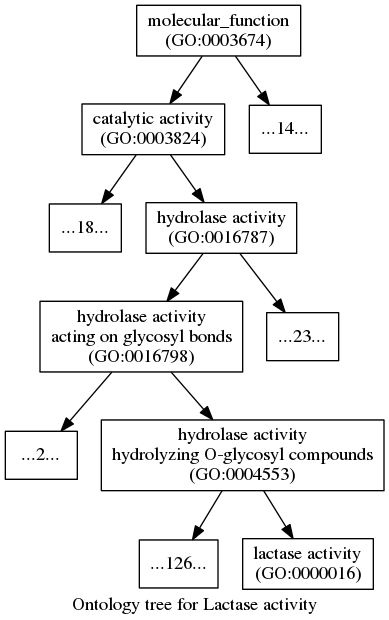

In [10]:
g = pgv.AGraph(directed=True)
for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)
print(g)
g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')
g.draw('graph.png')
Image("graph.png")

In [11]:
print(go_id)
refs = do_request(ensembl_server, 'ontology/descendants', go_id)
for go in refs:
    print(go['accession'], go['name'], go['definition'])

GO:0000016
GO:0004553 hydrolase activity, hydrolyzing O-glycosyl compounds "Catalysis of the hydrolysis of any O-glycosyl bond." [GOC:mah]
GO:0016798 hydrolase activity, acting on glycosyl bonds "Catalysis of the hydrolysis of any glycosyl bond." [GOC:jl]
GO:0016787 hydrolase activity "Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name for any enzyme of EC class 3." [ISBN:0198506732]
GO:0003824 catalytic activity "Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic." [GOC:vw, ISBN:0198506732]
GO:0003674 molecular_function "The actions of a sin